In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import sys
sys.path.insert(1, '/host/cassio/export03/data/opt/hippunfold_toolbox/hippunfold_toolbox')
import utils
import plotting
import os
import glob
from brainspace.gradient import GradientMaps
from brainspace.datasets import load_conte69
from brainspace.plotting import plot_hemispheres
from brainspace.mesh.mesh_io import read_surface
from brainspace.datasets import load_group_fc, load_parcellation, load_conte69


surf_lh, surf_rh = load_conte69()

In [5]:
# 1. specify the subjects and directories
micapipe_dir = '../../../publication-hippomaps/sourcedata/Micapipe_PNI'
hippunfold_dir = '../../../publication-hippomaps/hippunfold/PNI_v1.3.0_super/hippunfold'
tmp_dir = 'tmp_rsfMRI'
subs = ['PNC002', 'PNC003', 'PNC006', 'PNC007', 'PNC009', 'PNC010', 'PNC015','PNC016', 'PNC018','PNC019']
ses = '01'
micapipe='/data_/mica1/01_programs/micapipe-v0.2.0'

# 2. Prepare data and analysis parameters 
hemis = ['L','R']
labels = ['hipp']# ,'dentate'] 
sigma = 1 #Gaussian smoothing kernal sigma (mm)
ind = [range(419)]#, range(419,483)]
shp = [419]#,64]
clipaftertime = 210 # clip after this many TRs

# 3. Load neocortical surfaces for visualzation 
parcL = nib.load('/data/mica1/01_programs/micapipe-v0.2.0/parcellations/schaefer-400_conte69_lh.label.gii').darrays[0].data
parcR = nib.load('/data/mica1/01_programs/micapipe-v0.2.0/parcellations/schaefer-400_conte69_rh.label.gii').darrays[0].data
parc = np.concatenate((parcL,parcR))
c69_inf_lh= read_surface(micapipe + '/surfaces/fsLR-32k.L.inflated.surf.gii', itype='gii')
c69_inf_rh = read_surface(micapipe + '/surfaces/fsLR-32k.R.inflated.surf.gii', itype='gii')
labeling = load_parcellation('schaefer', scale=400, join=True)
atlas = 'schaefer-400'
# Read label for conte69
labels_c69 = np.loadtxt(open(micapipe + '/parcellations/' + atlas + '_conte69.csv'), dtype=int)
# Mask of the medial wall
mask_c69 = labels_c69 != 0

# 0. Map data to hippocmapal surface

In [58]:
!mkdir -p {tmp_dir}
shp = [419,64]

for sub in subs:
    if not glob.glob(f'{hippunfold_dir}/sub-{sub}/surf/sub-{sub}_hemi-{hemis[-1]}_space-T1w_den-2mm_label-{labels[-1]}_rsfMRI_smooth-{sigma}mm.func.gii'):

        # convert affines
        cmd1a = f'c3d_affine_tool '\
            f'-itk {micapipe_dir}/sub-{sub}/ses-{ses}/xfm/sub-{sub}_ses-{ses}_from-me_task-rest_bold_to-nativepro_mode-image_desc-affine_0GenericAffine.mat '\
            f'-o {tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine0.txt'
        !{cmd1a}
        cmd1b = f'c3d_affine_tool '\
            f'-itk {micapipe_dir}/sub-{sub}/ses-{ses}/xfm/sub-{sub}_ses-{ses}_from-nativepro_func_to-me_task-rest_bold_mode-image_desc-SyN_0GenericAffine.mat '\
            f'-inv '\
            f'-o {tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine1.txt'
        !{cmd1b}

        for h,hemi in enumerate(hemis):
            for l,label in enumerate(labels):
                #apply affines
                cmd2a = f'wb_command -surface-apply-affine '\
                    f'{hippunfold_dir}/sub-{sub}/surf/sub-{sub}_hemi-{hemi}_space-T1w_den-0p5mm_label-{label}_midthickness.surf.gii '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine0.txt '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff0.surf.gii'

                !{cmd2a}
                cmd2b = f'wb_command -surface-apply-affine '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff0.surf.gii '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine1.txt '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff1.surf.gii'
                !{cmd2b}

                # apply warp (Note this is actually the INVERSE warp)
                cmd3 = f'wb_command -surface-apply-warpfield '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff1.surf.gii '\
                    f'{micapipe_dir}/sub-{sub}/ses-{ses}/xfm/sub-{sub}_ses-{ses}_from-nativepro_func_to-me_task-rest_bold_mode-image_desc-SyN_1Warp.nii.gz '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_deform.surf.gii'
                !{cmd3}


                # sample
                cmd4 = f'wb_command -volume-to-surface-mapping '\
                    f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-me_task-rest_bold/volumetric/sub-{sub}_ses-{ses}_space-func_desc-me_preproc.nii.gz '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_deform.surf.gii '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_rsfMRI.func.gii '\
                    f'-enclosing'
                !{cmd4}

                # smooth
                cmd5 = f'wb_command -metric-smoothing '\
                    f'{hippunfold_dir}/sub-{sub}/surf/sub-{sub}_hemi-{hemi}_space-T1w_den-0p5mm_label-{label}_midthickness.surf.gii '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_rsfMRI.func.gii '\
                    f'{sigma} '\
                    f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_rsfMRI_smooth.func.gii '
                !{cmd5}

                # downsample
                func = nib.load(f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_rsfMRI_smooth.func.gii')
                out_array = np.ones((len(func.darrays),shp[l]))
                for k in range(len(func.darrays)):
                    data, f, v = utils.density_interp('0p5mm', '2mm',func.darrays[k].data, label,'nearest')
                    out_array[k,:] = data
                data_array = nib.gifti.GiftiDataArray(data=out_array)
                image = nib.gifti.GiftiImage()
                image.add_gifti_data_array(data_array)
                nib.save(image, f'{hippunfold_dir}/sub-{sub}/surf/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-{label}_rsfMRI_smooth-{sigma}mm.func.gii')
                
!rm -r {tmp_dir}

In [6]:
cdata_hipp = np.ones((np.sum(shp),2,clipaftertime,len(subs)))*np.nan
for s,sub in enumerate(subs):
    for h,hemi in enumerate(hemis):
        for l,label in enumerate(labels):
            cdata_hipp[ind[l],h,:,s] = nib.load(f'{hippunfold_dir}/sub-{sub}/surf/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-{label}_rsfMRI_smooth-{sigma}mm.func.gii').darrays[0].data.T[:,:clipaftertime]

FileNotFoundError: No such file or no access: '../../publication-hippomaps/hippunfold/PNI_v1.3.0_super/hippunfold/sub-PNC002/surf/sub-PNC002_hemi-L_space-T1w_den-2mm_label-hipp_rsfMRI_smooth-1mm.func.gii'

# 1. Intrinsic Timescale of hippocampal timeseries data

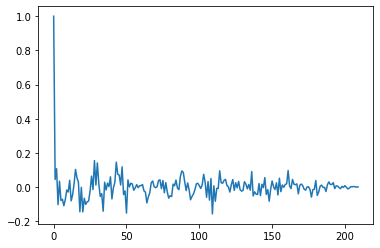

In [25]:
t = cdata_hipp[302,0,:,1]
m = np.mean(t)
var = np.var(t)
ndat = t - m
acf = np.correlate(ndat, ndat, 'full')[len(ndat)-1:] 
acf = acf / var / len(ndat)
plt.plot(acf)

In [26]:
def IntrinsicTimescale(data, TR=1, threshold=0):
    '''computes instrinsic timescale - the AUC of the autocorrelation up to the point 
    where the autocorrelation reaches threshold. 
    Input
      img: input ND data, time being the last dimension
    '''
    shp = data.shape
    i = data.reshape(-1, shp[-1])
    out = np.zeros(i.shape[0])
    for v in range(i.shape[0]):
        m = np.mean(i[v,:])
        var = np.var(i[v,:])
        ndat = i[v,:] - m
        acf = np.correlate(ndat, ndat, 'full')[len(ndat)-1:] 
        acf = acf / var / len(ndat)
        f = np.where(acf<=threshold)[0]
        if len(f)==0:
            out[v] = np.nan
        else:
            out[v] = f[0]
    out = np.reshape(out,shp[:-1])*TR
    return out

In [27]:
TR = nib.load(f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-me_task-rest_bold/volumetric/sub-{sub}_ses-{ses}_space-func_desc-me_preproc.nii.gz').header.get_zooms()[-1]
IntTS = np.ones((np.sum(shp),2,len(subs)))*np.nan
for s,sub in enumerate(subs):
    IntTS[:,:,s] = IntrinsicTimescale(cdata_hipp[:,:,:,s],TR, threshold=0)

/export03/data/opt/venv/lib/python3.8/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


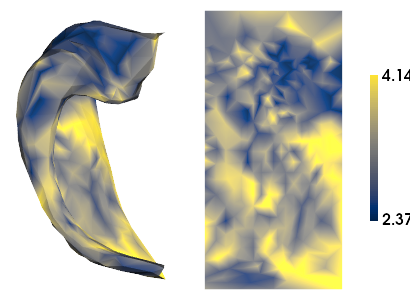

In [28]:
plotting.surfplot_canonical_foldunfold(np.nanmean(IntTS,axis=(1,2)), den='2mm', hemis=['L'], labels=labels, unfoldAPrescale=True, tighten_cwindow=True, cmap='cividis', share='row', color_bar='right', embed_nb=True)

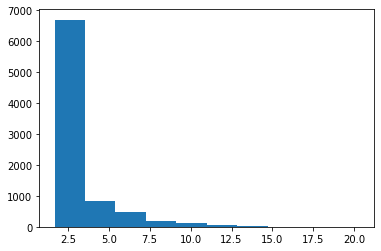

In [29]:
plt.hist(IntTS.flatten());

In [30]:
# save a copy of the 2D map
for l,label in enumerate(labels):    
    cdat = np.nanmean(IntTS,axis=(1,2))[ind[l]]
    data_array = nib.gifti.GiftiDataArray(data=cdat)
    image = nib.gifti.GiftiImage()
    image.add_gifti_data_array(data_array)
    nib.save(image, f'../maps/HippoMaps-initializationMaps/Dataset-PNI/MRI-7T-rsfMRI-IntTS_average-20_hemi-mix_den-2mm_label-{label}.shape.gii')

# 1. Calcualte ReHo

In [31]:
def kendall_w(expt_ratings):
    if expt_ratings.ndim!=2:
        raise 'ratings matrix must be 2-dimensional'
    m = expt_ratings.shape[0] #raters
    n = expt_ratings.shape[1] # items rated
    denom = m**2*(n**3-n)
    rating_sums = np.sum(expt_ratings, axis=0)
    S = n*np.var(rating_sums)
    return 12*S/denom
def calc_reho(ts,F):
    # note ts should be shape VxT
    reho = np.ones((ts.shape[0]))*np.nan
    for v in range(ts.shape[0]):
        frows = np.unique(np.where(np.isin(F,v))[0])
        verts = np.unique(F[frows,:])
        reho[v] = kendall_w(ts[verts,:])
    return reho

In [34]:
reho = np.ones((np.sum(shp),2,len(subs)))*np.nan
for s,sub in enumerate(subs):
    for h,hemi in enumerate(hemis):
        for l,label in enumerate(labels):
            Fname = f'/host/cassio/export03/data/opt/hippunfold_toolbox/resources/canonical_surfs/tpl-avg_space-unfold_den-2mm_label-{label}_midthickness.surf.gii'
            F = nib.load(Fname).get_arrays_from_intent('NIFTI_INTENT_TRIANGLE')[0].data
            reho[ind[l],h,s] = calc_reho(cdata_hipp[ind[l],h,:,s],F)

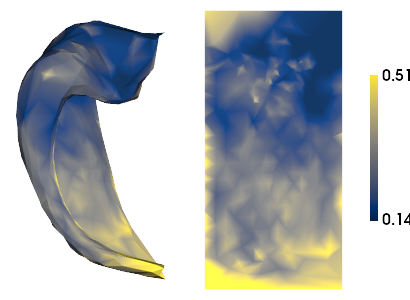

In [35]:
plotting.surfplot_canonical_foldunfold(np.nanmean(reho,axis=(1,2)), den='2mm', hemis=['L'], labels=labels, unfoldAPrescale=True, tighten_cwindow=True, cmap='cividis', share='row', color_bar='right', embed_nb=True)

In [68]:
# save a copy of the 2D map
for l,label in enumerate(labels):    
    cdat = np.nanmean(reho,axis=(1,2))[ind[l]]
    data_array = nib.gifti.GiftiDataArray(data=cdat)
    image = nib.gifti.GiftiImage()
    image.add_gifti_data_array(data_array)
    nib.save(image, f'../maps/HippoMaps-initializationMaps/Dataset-PNI/MRI-7T-rsfMRI-ReHo_average-20_hemi-mix_den-2mm_label-{label}.shape.gii')

## TODO: calculate tSNR before TS gets processed

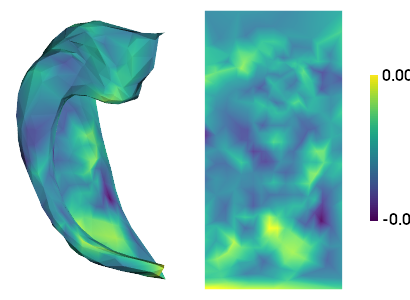

In [37]:
tSNR = np.mean(cdata_hipp,axis=2) / np.std(cdata_hipp,axis=2)
plotting.surfplot_canonical_foldunfold(np.nanmean(tSNR,axis=(1,2)), den='2mm', hemis=['L'], labels=labels, unfoldAPrescale=True, share='row', color_bar='right', zoom=1.7, embed_nb=True)

# 3. rs functional connectivity (FC)

In [46]:
cdata_hipp.shape

(419, 2, 210, 10)

In [47]:
#run gradients for all subjects
FC = np.ones((np.sum(shp),200,2,len(subs)))*np.nan

for s,sub in enumerate(subs):
    neo_ts = nib.load(f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-me_task-rest_bold/surf/sub-{sub}_ses-{ses}_surf-fsLR-32k_desc-timeseries_clean.shape.gii').darrays[0].data[:clipaftertime,:]
    neo_ts_parc = np.ones((neo_ts.shape[0],400))
    for i in range(400):
         neo_ts_parc[:,i] = np.nanmean(neo_ts[:,parc==(i+1)],axis=1)
    neo_tsL = neo_ts_parc[:,:200]   
    neo_tsR = neo_ts_parc[:,200:]
    for h,hemi in enumerate(hemis):
        if hemi == 'L':
            FC[:,:,h,s] = np.corrcoef(cdata_hipp[:,h,:,s],neo_tsL.T)[:np.sum(shp),np.sum(shp):]
        else:            
            FC[:,:,h,s] = np.corrcoef(cdata_hipp[:,h,:,s],neo_tsR.T)[:np.sum(shp),np.sum(shp):]

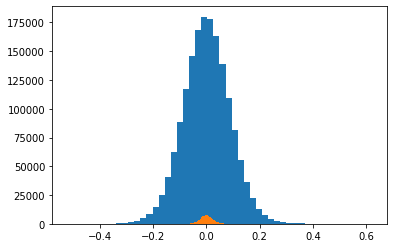

In [48]:
plt.hist(FC.flatten(),bins=50);
plt.hist(np.nanmean(FC,axis=(2,3)).flatten(),bins=50);

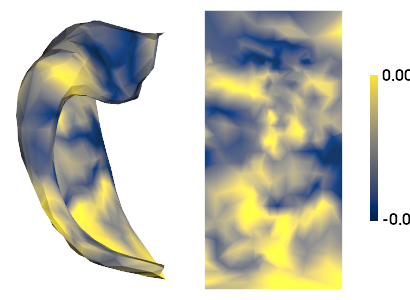

In [49]:
plotting.surfplot_canonical_foldunfold(np.nanmean(FC,axis=(1,2,3)), den='2mm', hemis=['L'], labels=labels, unfoldAPrescale=True, tighten_cwindow=True, cmap='cividis', share='row', color_bar='right', embed_nb=True)

In [73]:
# save a copy of the 2D map
for l,label in enumerate(labels):    
    cdat = np.nanmean(FC,axis=(1,2,3))[ind[l]]
    data_array = nib.gifti.GiftiDataArray(data=cdat)
    image = nib.gifti.GiftiImage()
    image.add_gifti_data_array(data_array)
    nib.save(image, f'../maps/HippoMaps-initializationMaps/Dataset-PNI/MRI-7T-rsfMRI-avgFCneocort_average-20_hemi-mix_den-2mm_label-{label}.shape.gii')

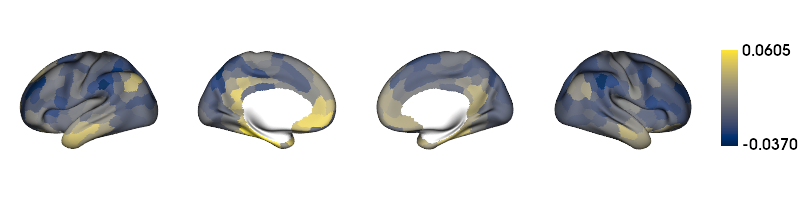

In [50]:
mc = np.ones([surf_lh.n_points + surf_rh.n_points])*np.nan
for h,hemi in enumerate(hemis):
    for i in range(200):
        mc[parc==(i+1+(h*200))] = np.nanmean(FC[:,i,h,:],axis=(0,1))
plot_hemispheres( c69_inf_lh,  c69_inf_rh,array_name=np.hsplit(mc,1), 
                 size=(800,200), color_bar=True, cmap='cividis', embed_nb=True,nan_color=(1, 1, 1, 1))

## check consistency

In [51]:
feats = ["IntTS", "ReHo", "FC"]
mfcorr = []
sdfcorr = []

corr = np.corrcoef(IntTS.reshape((np.sum(shp),-1)).T)
fcorr = corr[np.triu_indices(len(subs)*2,k=1)]
mfcorr.append(np.nanmean(fcorr))
sdfcorr.append(np.nanstd(fcorr))

corr = np.corrcoef(reho.reshape((np.sum(shp),-1)).T)
fcorr = corr[np.triu_indices(len(subs)*2,k=1)]
mfcorr.append(np.nanmean(fcorr))
sdfcorr.append(np.nanstd(fcorr))

corr = np.corrcoef(FC.reshape((np.sum(shp),-1)).T)
fcorr = corr[np.triu_indices(len(subs)*2*200,k=1)]
mfcorr.append(np.nanmean(fcorr))
sdfcorr.append(np.nanstd(fcorr))

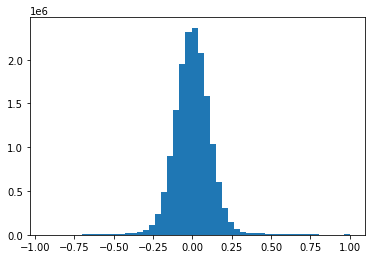

In [52]:
plt.hist(corr.flatten(),bins=50);

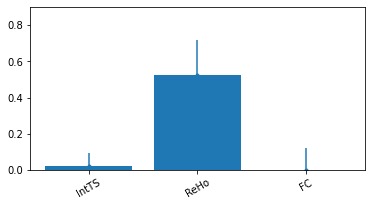

In [53]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3*2,3))
plt.bar(range(3),mfcorr)
plt.errorbar(range(3),mfcorr, yerr=sdfcorr, fmt=".")
plt.xticks(ticks=range(3),labels=feats,rotation=30)
plt.ylim([0,.9]);

# 4. Gradientts of differential FC

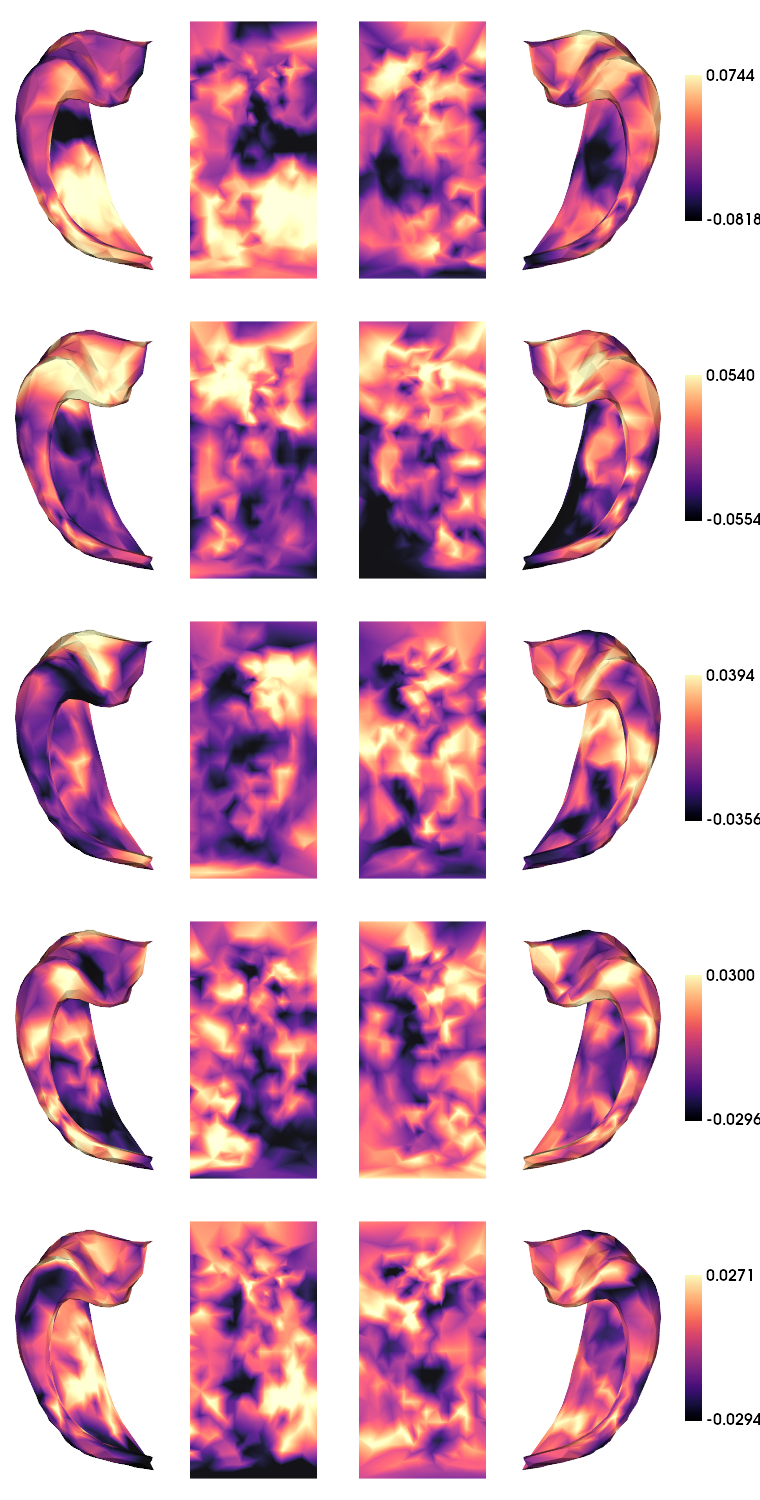

In [55]:
ngrads = 5
gradients = np.zeros((np.sum(shp),2,ngrads))
for h,hemi in enumerate(hemis):
    gm = GradientMaps(n_components=ngrads, kernel='normalized_angle', random_state=0, alignment='procrustes')
    gm.fit(np.nanmean(FC[:,:,h,:],axis=(2)))
    gradients[:,h,:] = gm.gradients_
    
# manually flip any L-R mismatch
gradients[:,1,:] = -gradients[:,1,:]
    
plotting.surfplot_canonical_foldunfold(gradients, den='2mm', hemis=hemis, labels=labels, unfoldAPrescale=True, tighten_cwindow=True, cmap='magma', share='row', color_bar='right', embed_nb=True)

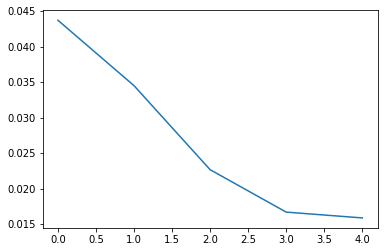

In [56]:
plt.plot(gm.lambdas_)

In [77]:
# save a copy of the 2D map
for l,label in enumerate(labels):    
    cdat = gm.gradients_[ind[l],:]
    data_array = nib.gifti.GiftiDataArray(data=cdat)
    image = nib.gifti.GiftiImage()
    image.add_gifti_data_array(data_array)
    nib.save(image, f'../maps/HippoMaps-initializationMaps/Dataset-PNI/MRI-7T-rsfMRI-FCG1to5_average-20_hemi-mix_den-2mm_label-{label}.shape.gii')

/export03/data/opt/venv/lib/python3.8/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


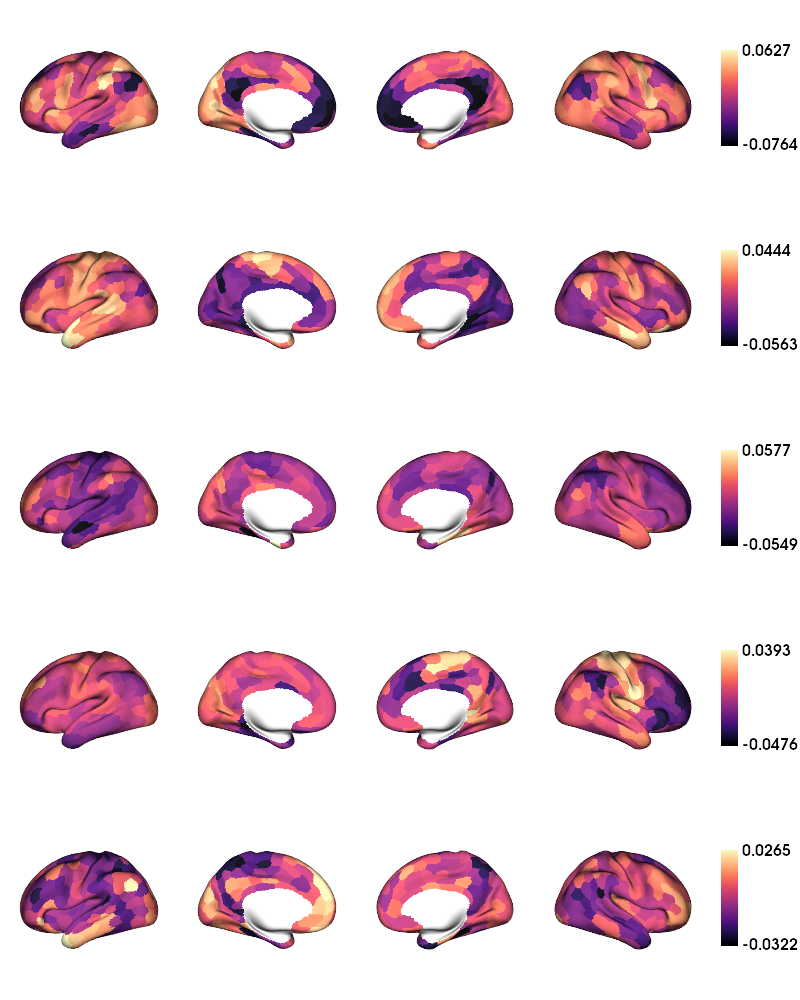

In [57]:
# look only at FC to the rest of the neocortex for the top-bottom 10% of each gradient

nverts = np.sum(shp)
nvertsplit = int(nverts*.25)

diffval = np.ones([surf_lh.n_points + surf_rh.n_points,ngrads])*np.nan
botval = np.ones(surf_lh.n_points + surf_rh.n_points)*np.nan
topval = np.ones(surf_lh.n_points + surf_rh.n_points)*np.nan
for g in range(ngrads):
    for h,hemi in enumerate(hemis):
        bot = np.argpartition(gradients[:,h,g],nvertsplit)[:nvertsplit]
        top = np.argpartition(gradients[:,h,g],-nvertsplit)[-nvertsplit:]
        for i in range(200):
            botval[parc==(i+1+(h*200))] = np.nanmean(FC[bot,i,h,:],axis=(0,1))
            topval[parc==(i+1+(h*200))] = np.nanmean(FC[top,i,h,:],axis=(0,1))
        diffval[:,g] = topval-botval
plot_hemispheres( c69_inf_lh,  c69_inf_rh,array_name=np.hsplit(diffval,ngrads), 
                 size=(800,200*ngrads), color_bar=True, cmap='magma', embed_nb=True,nan_color=(1, 1, 1, 1))

# 4. Gradients of differential hippocampal FC, averaging hemis

/export03/data/opt/venv/lib/python3.8/site-packages/brainspace/plotting/utils.py:303: RuntimeWarning: All-NaN axis encountered
  a, b = np.nanmin(x), np.nanmax(x)


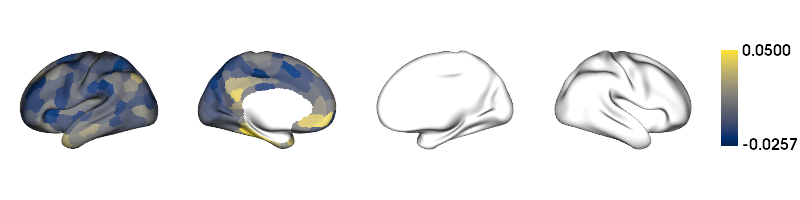

In [58]:
mc = np.ones([surf_lh.n_points + surf_rh.n_points])*np.nan
for i in range(200):
    mc[parc==(i+1)] = np.nanmean(FC[:,i,:,:],axis=(0,1,2))
plot_hemispheres( c69_inf_lh,  c69_inf_rh,array_name=np.hsplit(mc,1), 
                 size=(800,200), color_bar=True, cmap='cividis', embed_nb=True,nan_color=(1, 1, 1, 1))

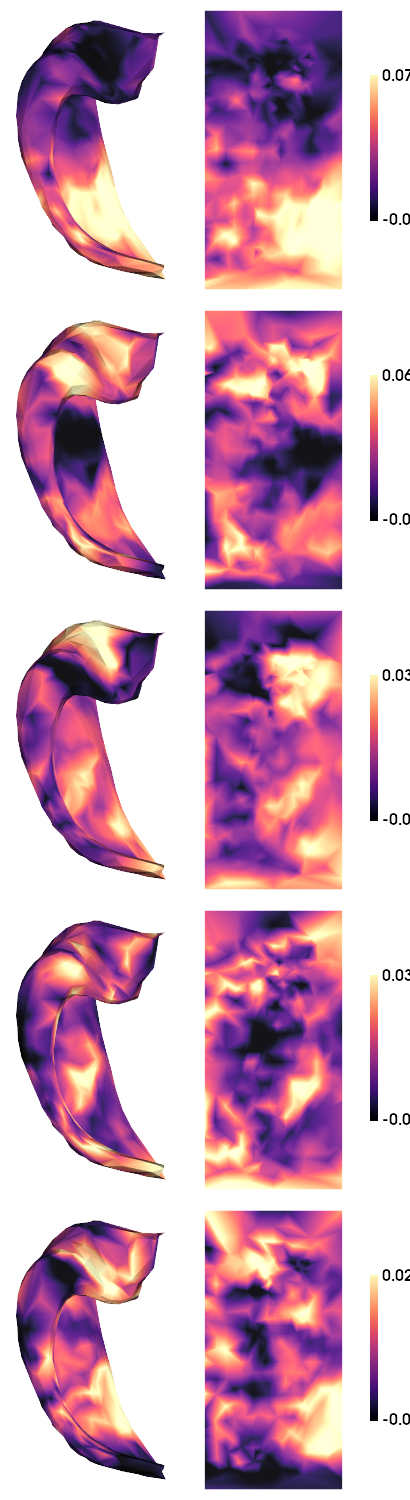

In [59]:
ngrads = 5
gm = GradientMaps(n_components=ngrads, kernel='normalized_angle', random_state=0, alignment='procrustes')
gm.fit(np.nanmean(FC,axis=(2,3)))
    
plotting.surfplot_canonical_foldunfold(gm.gradients_, den='2mm', hemis=['L'], labels=labels, unfoldAPrescale=True, tighten_cwindow=True, cmap='magma', share='row', color_bar='right', embed_nb=True)

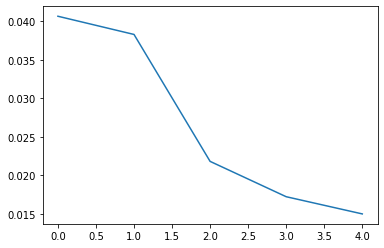

In [60]:
plt.plot(gm.lambdas_)

/export03/data/opt/venv/lib/python3.8/site-packages/brainspace/plotting/utils.py:303: RuntimeWarning: All-NaN axis encountered
  a, b = np.nanmin(x), np.nanmax(x)
/export03/data/opt/venv/lib/python3.8/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


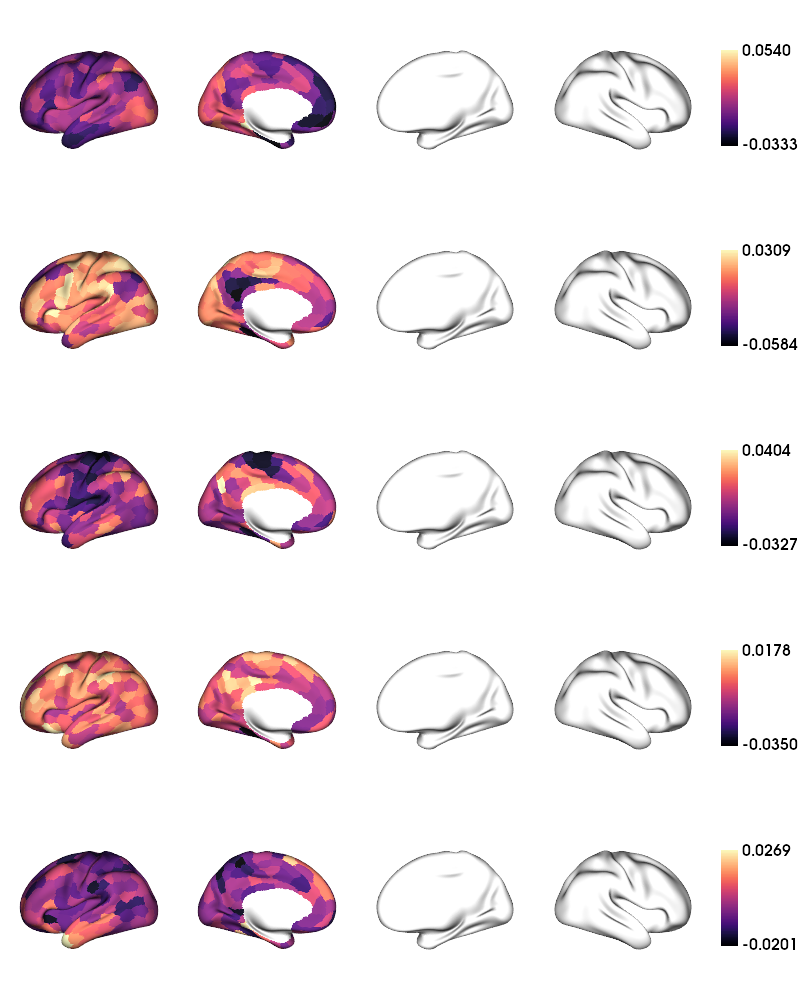

In [61]:
# look only at FC to the rest of the neocortex for the top-bottom 10% of each gradient

nverts = np.sum(shp)
nvertsplit = int(nverts*.25)

diffval = np.ones([surf_lh.n_points + surf_rh.n_points,ngrads])*np.nan
botval = np.ones(surf_lh.n_points + surf_rh.n_points)*np.nan
topval = np.ones(surf_lh.n_points + surf_rh.n_points)*np.nan
for g in range(ngrads):
    bot = np.argpartition(gm.gradients_[:,g],nvertsplit)[:nvertsplit]
    top = np.argpartition(gm.gradients_[:,g],-nvertsplit)[-nvertsplit:]
    for i in range(200):
        botval[parc==(i+1)] = np.nanmean(FC[bot,i,:,:],axis=(0,1,2))
        topval[parc==(i+1)] = np.nanmean(FC[top,i,:,:],axis=(0,1,2))
    diffval[:,g] = topval-botval
plot_hemispheres( c69_inf_lh,  c69_inf_rh,array_name=np.hsplit(diffval,ngrads), 
                 size=(800,200*ngrads), color_bar=True, cmap='magma', embed_nb=True,nan_color=(1, 1, 1, 1))